# AS, WITH
Al aumentar la complejidad de las *querys* que realizamos, encontraremos que pueden volverse muy extensas y, quizás, difíciles de comprender. Para simplificar esto, puede utilzarse la instrucción **WITH ... AS ...**.

Supongamos que deseamos realizar una consulta sobre "mascotas mayores" (dentro de la siguiente tabla), podremos aplicar lo indicado a continuación:

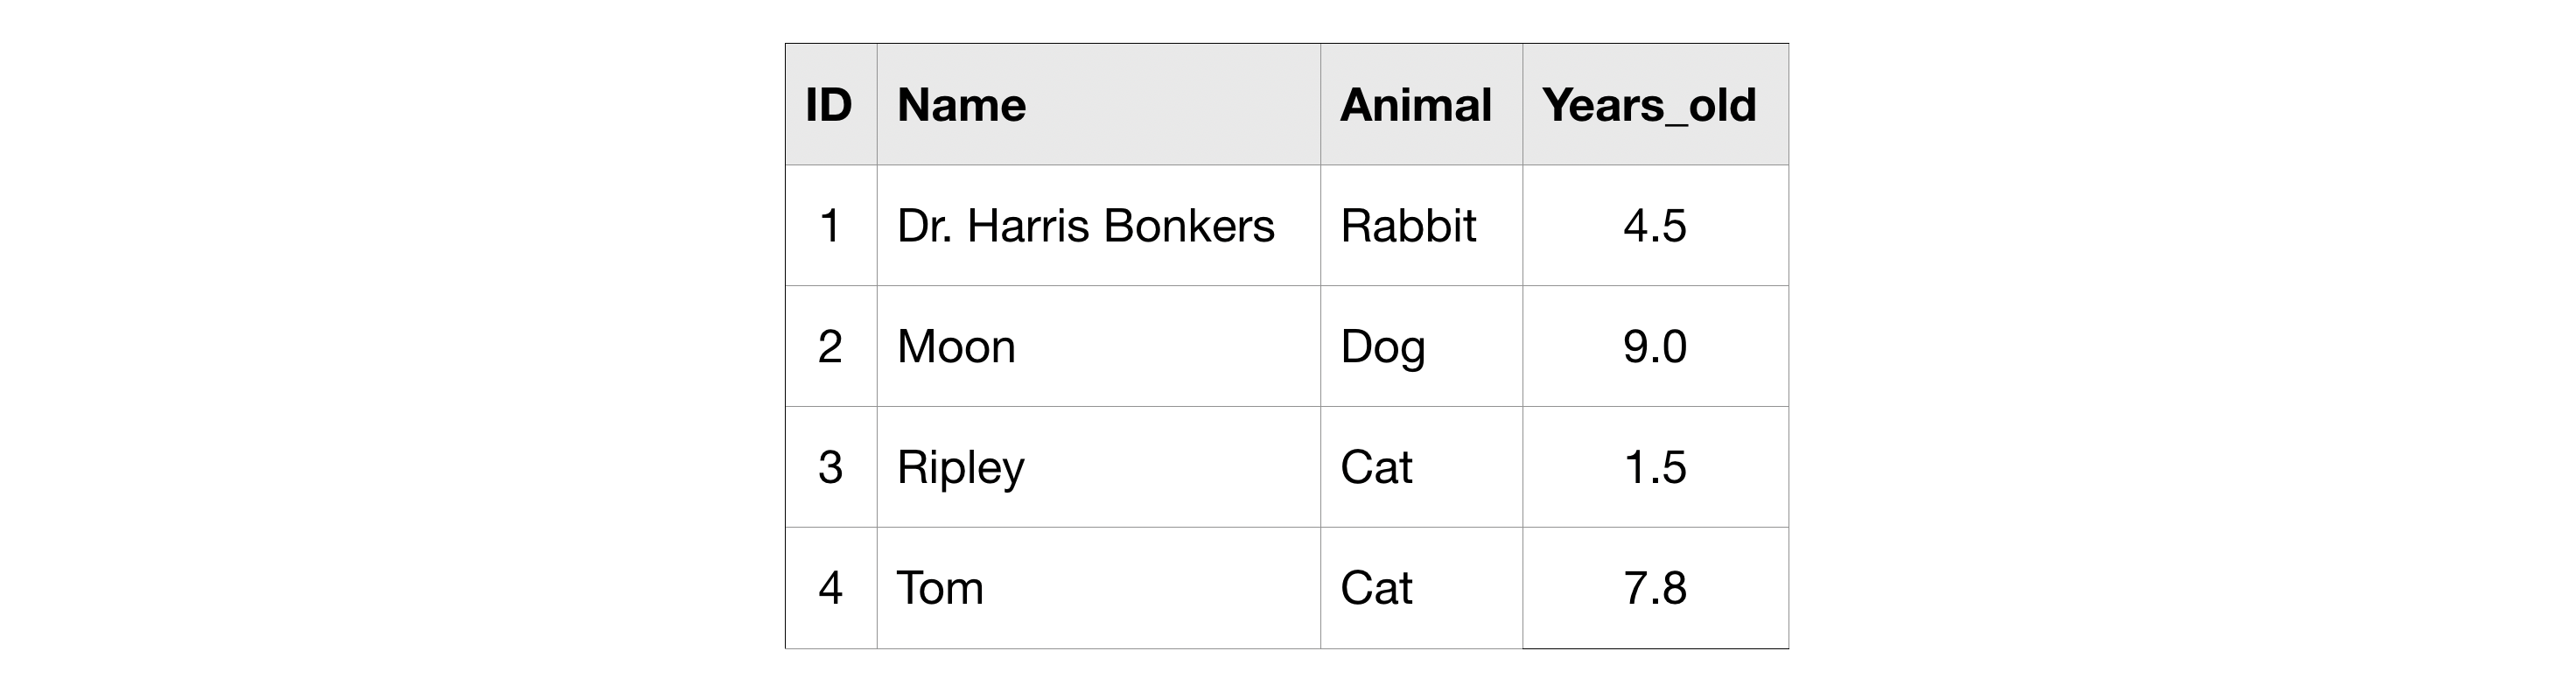

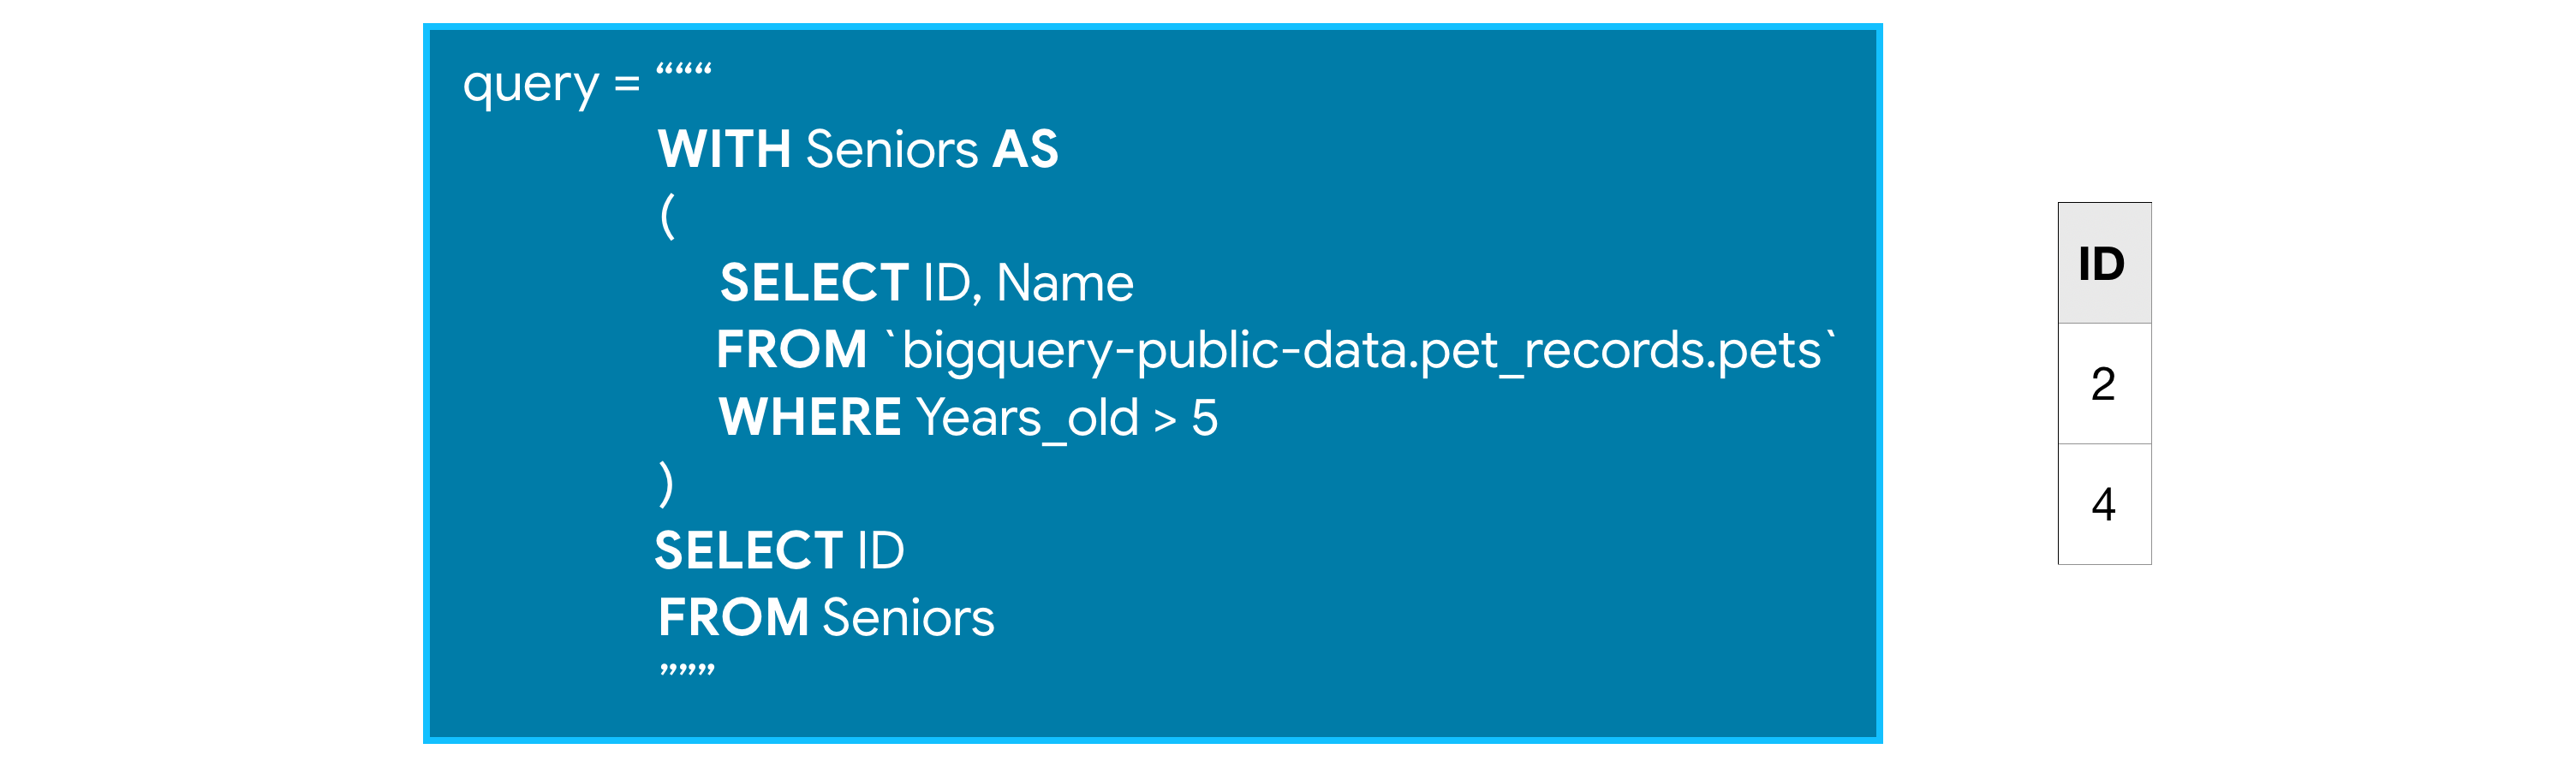

Esta manera de combinar *with* y *as* forma lo que se conoce como **CTE *Common Table Expression***, una especie de **consulta intermedia**. Así, podremos realizar una *query* sobre la tabla parcial intermedia, simplificando la lectura y comprensión de la misma.

Cabe mencionar que las *querys parciales* sólo existen dentro de la misma *query*, por tanto no podremos consultarlas desde otra externa.

## Práctica
Vamos a trabajar con el **dataset 'chicago_taxi_trips'** para aplicar lo aprendido.

1. Inspeccionar la data y analizar si ciertos inconvenientes con algunos datos son aparentemente obvios. 

In [5]:
from google.cloud import bigquery

client = bigquery.Client()

dataset_ref = client.dataset('chicago_taxi_trips', project='bigquery-public-data')
dataset = client.get_dataset(dataset_ref)

tables = list(client.list_tables(dataset))
for table in tables:
    print(table.table_id)

taxi_trips


In [6]:
taxi_trips_table_ref = dataset_ref.table('taxi_trips')
taxi_trips_table = client.get_table(taxi_trips_table_ref)

client.list_rows(taxi_trips_table, max_results=5).to_dataframe()

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,extras,trip_total,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location
0,7f892ec7515bd913c549b6191d4f1210dab6bd48,51d13e9ec1a04be36d87a3746e0e4f8c68ca5ed59e6f7a...,2019-02-16 13:30:00+00:00,2019-02-16 14:15:00+00:00,2662,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Credit Card,City Service,NaN,NaN,None,NaN,NaN,None
1,3343feb9ec86b7583eda014b283a73607a9bac0c,6b6ceb851bc1c33fcad40360a39cdd774c3269b1a13464...,2019-02-22 17:30:00+00:00,2019-02-22 17:30:00+00:00,13,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,Cash,Chicago Carriage Cab Corp,NaN,NaN,None,NaN,NaN,None
2,61057274be2441292e556305abfaa5c43eace54a,664a30bd4642ae849cb593c18f9bf5f3def292f714d1b2...,2019-03-01 16:30:00+00:00,2019-03-01 16:30:00+00:00,72,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,Credit Card,City Service,NaN,NaN,None,NaN,NaN,None
3,f2e00f30b9575fc6e1eb18dded32b7ee3add2f56,664a30bd4642ae849cb593c18f9bf5f3def292f714d1b2...,2019-03-01 16:45:00+00:00,2019-03-01 16:45:00+00:00,31,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,Cash,City Service,NaN,NaN,None,NaN,NaN,None
4,4f027f16e2fba80ddf7504b4b1a19c1dc0a6113c,664a30bd4642ae849cb593c18f9bf5f3def292f714d1b2...,2019-03-01 16:45:00+00:00,2019-03-01 16:45:00+00:00,137,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,Cash,City Service,NaN,NaN,None,NaN,NaN,None


Del primer análisis, podemos ver ciertas columnas con valores que traerán complicaciones, por ejemplo, aparecen viajes con duración/distancia 0, así como valores no admitidos en campos como *'location'*.

2. Realizar una consulta que devuelva la cantidad de viajes por año.

In [8]:
trips_by_year_query = '''
SELECT EXTRACT(YEAR from trip_start_timestamp) AS year, COUNT(1) AS NumTrips
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
GROUP BY year
ORDER BY year
'''

safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
trips_by_year_query_job = client.query(trips_by_year_query, job_config=safe_config)
trips_by_year = trips_by_year_query_job.to_dataframe()

trips_by_year

,year,NumTrips
0,2013,27217716
1,2014,37395436
2,2015,32385875
3,2016,31759339
4,2017,24988003
5,2018,20732088
6,2019,16477365
7,2020,3889032
8,2021,3948045
9,2022,672738


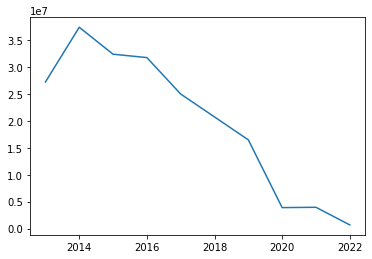

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(trips_by_year.year, trips_by_year.NumTrips)

3. Tomando de referencia el anterior, ahora realizar una inspección sobre el año 2017.

<AxesSubplot:xlabel='month'>

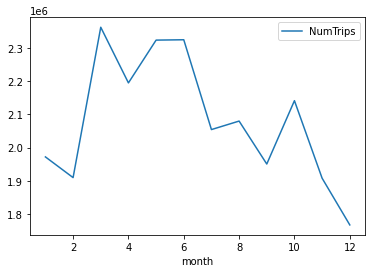

In [16]:
trips_by_month_query = '''
SELECT EXTRACT(MONTH from trip_start_timestamp) AS month, COUNT(1) AS NumTrips
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE EXTRACT(YEAR from trip_start_timestamp) = 2017
GROUP BY month
ORDER BY month
'''

safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
trips_by_month_query_job = client.query(trips_by_month_query, job_config=safe_config)
trips_by_month = trips_by_month_query_job.to_dataframe()

# trips_by_month
trips_by_month.set_index('month').plot()

5. Realizar una consulta que muestre, por cada hora del día del dataset, la cantidad de viajes y la velocidad promedio. NOTA: utilizar una pre-consulta, para filtrar solo los viajes que nos importan:
- 'trip_start_timestamp': entre 2017-01-01 y 2017-07-01
- 'trip_seconds' > 0 y 'trip_miles' > 0

In [18]:
speeds_query = '''
WITH RelevantRides AS (
    SELECT EXTRACT(HOUR from trip_start_timestamp) AS hour, trip_seconds, trip_miles
    FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
    WHERE trip_start_timestamp >= "2017-01-01" AND
          trip_start_timestamp <= "2017-07-01" AND
          trip_seconds > 0 AND trip_miles > 0 
)


SELECT hour, COUNT(1) AS NumTrips, (SUM(trip_miles) / SUM(trip_seconds) * 3600) AS avg_mph
FROM RelevantRides
GROUP BY hour
ORDER BY hour
'''

safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
speeds_query_job = client.query(speeds_query, job_config=safe_config)
speeds = speeds_query_job.to_dataframe()

speeds
# trips_by_month.set_index('month').plot()

,hour,NumTrips,avg_mph
0,0,320766,20.207924
1,1,266529,18.937621
2,2,210147,18.777070
3,3,159668,20.158048
4,4,122183,26.736014
5,5,119312,30.769172
6,6,182738,24.588313
7,7,358406,17.735967
8,8,541775,15.079892
9,9,565548,16.543882


### Dudas
Este último ejercicio, intuitivamente me salió resolverlo de la manera en que lo hice (y que fuera marcado como correcto en Kaggle), pero, por otro lado, el dato de la velocidad promedio no sería correcto de obtenerse así, sumando la distancia total acumulada y dividiéndolo por el tiempo total acumulado, en cambio, creo que debería realizarse obteniendo la velocidad de cada viaje y promediando luego todas, pero no sé si es posible de obtener ese valor (por esto, no sé si la forma en que se hizo es simplemente a modo de tener una idea cuantitativa de la congestión del tráfico en cada rango horario y no el cálculo real de la velocidad promediode todos los viajes)